# Table of Contents

- [RNN](#rnn)
- [Exercises](#exercises)

## Housekeeping



-   Some references I've been giving throughout the course
    -   [Official pytorch tutorials](https://pytorch.org/tutorials/)
        -   Example and exercise today comes from the pytorch tutorial on rnn
    -   [Deep Learning Book, Ch.10 on RNN](https://www.deeplearningbook.org/contents/rnn.html)
    -   [Dive Into Deep Learning Ch. 8, RNN](https://d2l.ai/chapter_recurrent-neural-networks/index.html)
    -   [RNN chapter of Hands-On Machine Learning](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch15.html#idm45728453105336)
-   Today's url
    -   https://git.io/ml2021-10
-   Email if you need help!



## Image Data Paradigm



-   So, until now, we've been thinking of data as some fixed point in
    some vector space, that we are try to classify with a label
-   An image is a $c \times w \times h$ sized vector, now generally c,
    w, and h are fixed but w and h might be changed between different
    images (depending on the camera used, have different resolutions)
    -   With CNN global pooling layers can be used to have a network that
        doesn't depend on a fixed size image
-   Conceptually, each image is a single, independent unit
-   But what about data that doesn't fit into this paradigm?
    -   Variable sized datasets, where context is important, and continuously updated
    -   Text: sentences can be variably lengthed, and the words I use
        change the context, change the meaning
    -   Video: self-driving cars need to find and anticipate the
        trajectories of other cars and people



## Sequences



-   We want to develop models that can operate on *sequences* of
    arbitrary length in order to determine their output
-   Can be a simple task: take a movie review and classify whether its
    positive (the reviewer liked the movie) or negative (the reviewer
    hated the movie)
-   Slightly more complex: predict the next element of a time series,
    say predict the movement of the price of a stock given the
    historical data
    -   This can also be: predict the next word given an input sentence,
        this is all the text generators like GPT-2/3 are trained to do
-   Very complex: take an input sentence and produce an audio file
    imitating a person speaking that text, or take a sentence in one
    language and produce a translation in another language
    -   This is a sequence to sequence task, or seq2seq



## Recurrent Neurons <a id="rnn" />



-   In order to be able to accomodate arbitrarily lengthed sequences, we
    need to modify our layer a bit (today, think of fully-connected
    layers)
-   We break the data up into time steps (which could be real time steps
    for stock prices or audio, or could be single word for text)



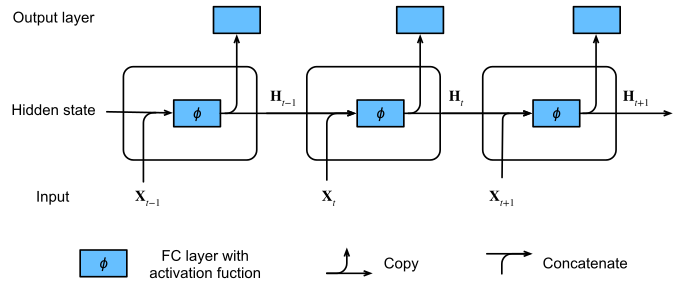

In [ ]:
# http://d2l.ai/chapter_recurrent-neural-networks/rnn.html
Image('rnn.png')

-   For each timestep, we pass in the input as usual, but we will also
    keep a *hidden state*, which also gets passed in
-   We then also have two outputs, the output layer as for our regular
    neurons, but also the *updated* hidden state, which can be passed in
    as an input to the next time step
    - As the hidden state occurs again in the computation, we call it a *recurrent* computation.
    - From the free dictionary: recurrent, *adj.* 1. Occurring or appearing again or repeatedly.
-   At the first timestep, we need to pass some hidden state, which we
    usually take as just a 0 vector of the right size



## Unrolled in time



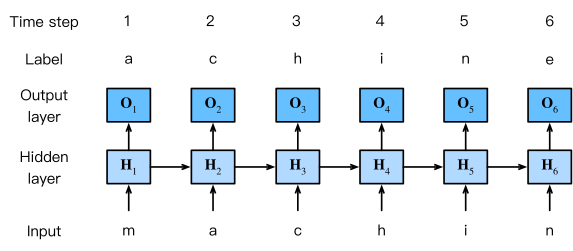

In [ ]:
# An rnn being trained to predict the next letter in a sequence
Image('rnn-train.png')

-   As we proceed through the sequence, the hidden state gets updated,
    and the output should reflect the context of all the previous
    datapoints in the sequence
-   Mathematically: $\mathbf{h_t} = \phi(W_x \mathbf{x_t} + W_h \mathbf{h_{t-1}} + \mathbf{b_h}) $
    -   $\phi$ is an activation function (e.g. tanh or ReLU), $W_x$
        and $W_h$ are weight matrices to be learnt, $b_h$ is a bias
        vector, $x_t$ is the input of time t, and
        $h_t$ the hidden state
    -   Note that the weight matrices are just short-hand ways of writing a *fully-connected layer*
    -   So, you could think of it as, the current input $x_t$ and the previous hidden state $h_{t-1}$ get concatenated together and passed through a fully-connected layer and get output as the new output $y_t$ and the new hidden state $h_t$ which holds the updated context
    -   If you're doing a task which requires processing a sequence to a single output, you can just ignore the intermediate states
- We can create the output $y_t$ from the hidden state: $\mathbf{y_t} = softmax(W_y \mathbf{h_t} + \mathbf{b_y})$
  - Here, we're assuming a classification task, so passing through a softmax, if we had many layers, this could be replaced by a ReLU or tanh or so on

## RNN with One Hidden Layer



![img](https://github.com/uos-computing-for-particle-physics/10-rnn-nyw-pathfinder/blob/master/rnn2n.png?raw=1)



-   A recurrent neuron embedded in a single hidden layer neural network
-   The output can be read out at any point in time (stock prediction, predict where a particle will go next),
    or ignored until the end (movie review analysis, initial state particle properties from detector hits)
-   When training, ordinary backpropagation starting from a loss applied
    to the final softmax output will calculate the gradients through the
    unrolled hidden connections
    -   Pytorch is keeping track of the computational graph, the weights
        will appear multiple times in the backpropagation



## RNN with Two Hidden Layers



![img](https://github.com/uos-computing-for-particle-physics/10-rnn-nyw-pathfinder/blob/master/rnn5nr.png?raw=1)



-   Several recurrent layers can be connected together, the output of
    each layer propagates through a single datapoint, the hidden state
    propagates across time
-   Notably, we see the hidden state of the first layer doesn't interact
    at all with any data from the subsequent layers



## In PyTorch



-   The implementation in pytorch is rather straightfoward, we just need
    to keep track of both the output and hidden state
-   We also have a utility function the user can call to initially generate the hidden state



In [ ]:
import torch.nn as nn
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1)
    hidden = torch.tanh(self.i2h(combined))
    output = self.h2o(hidden)
    return output, hidden
  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

## An example application: Names to Country of Origin



Let's download some data:

In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2021-05-12 13:16:50--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.149.70, 99.86.149.104, 99.86.149.108, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.149.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.08s   

2021-05-12 13:16:50 (33.9 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Ital

The data consists of files, each named for a country, and the file
contents are lines of family names. We read the data and turn unicode
characters (can represent all letters) into their ASCII equivalents
(represents only basic english letters).



In [ ]:
import unicodedata
import string
from glob import glob
files = glob("data/names/*.txt")
# restrict the letters we consider to ascii (plain english) only
all_letters = string.ascii_letters+" .,;'"
n_letters = len(all_letters)

# helper function to convert unicode to ascii
def unicodeToAscii(s):
  return ''.join(c for c in unicodedata.normalize("NFD", s)
    if unicodedata.category(c) != "Mn" and c in all_letters)

print(unicodeToAscii('Ślusàrski'))

Slusarski


Next, we read the data from the files into a dictionary.



In [ ]:
import os

# holds a dictionary from language name -> list of names from that language
category_lines = {}
# list of all the languages we consider
all_categories = []

# read the list of names, process through our unicode->ascii function
def readLines(filename):
  lines = open(filename, encoding='utf-8').read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]

# run the functions over all files
for filename in files:
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readLines(filename)
  category_lines[category] = lines

# our output will be a vector n_categories long corresponding to 
# the network's assigned probability for each language
n_categories = len(all_categories)
print(n_categories, all_categories)
print(category_lines['Korean'][:8])

18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
['Ahn', 'Baik', 'Bang', 'Byon', 'Cha', 'Chang', 'Chi', 'Chin']


Now, we make some functions which turn the datapoints, which consists
of strings of letters, into pytorch tensors. We have a one-hot
encoding, so a name gets turned into a letter sequence, each letter is
a vector where there is a 1 at the position representing the
particular letter.

Note that we are leaving open the possibility for batches, which are typically in the *second* position in RNNs for technical reasons, so you have an input tensor of `(sequence length, batch size, input size)`.

In [ ]:
import torch

# the position we set to 1 is just the index of the letter in the all_letters array
def letterToIndex(letter):
  return all_letters.find(letter)

# create a tensor shape (len(all_letters),) with the appropriate index on
def letterToTensor(letter):
  tensor = torch.zeros(1,n_letters)
  tensor[0][letterToIndex(letter)] = 1
  return tensor

# create a tensor [len(word), 1=batch_size, len(all_letter)] and set each letter
def lineToTensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for li, letter in enumerate(line):
    tensor[li][0][letterToIndex(letter)] = 1
  return tensor

# test the functions
print(letterToTensor('J'))
print(lineToTensor("Jones").shape)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


We can pass each letter tensor in the sequence through the RNN.



In [ ]:
# create a tensor from a name, and pass the first letter through the rnn
rnn=RNN(57,128,n_categories)
input = lineToTensor("Albert")
hidden = rnn.initHidden()
output, hidden = rnn(input[0], hidden)
# if everything is working we should have some output
print(output)

tensor([[-0.0651,  0.0135,  0.0528, -0.0395,  0.0697,  0.0554, -0.0645,  0.0225,
         -0.0757, -0.0323, -0.0532, -0.0400, -0.0180, -0.0544,  0.0043, -0.0420,
         -0.0806, -0.0255]], grad_fn=<AddmmBackward>)


Lets create some functions which will pick out a datapoint from our
dictionary at random.



In [ ]:
import random

# pick a random language, pick a random name from that language, 
# convert to a tensor, with corresponding output index for the language
def randomTrainingExample():
  category = random.choice(all_categories)
  line = random.choice(category_lines[category])
  category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
  line_tensor = lineToTensor(line)
  return category, line, category_tensor, line_tensor

for i in range(10):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  print('category =', category, '/ line =', line)

category = Vietnamese / line = Mach
category = Spanish / line = Martell
category = French / line = Paquet
category = German / line = Holzknecht
category = Japanese / line = Okuma
category = Italian / line = Cracchiolo
category = Portuguese / line = Castro
category = Japanese / line = Kajiwara
category = Dutch / line = Hofwegen
category = Dutch / line = Nifterick


Here is
a function to pass through and update the network on a single name.



In [ ]:
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(rnn.parameters())

def train(category_tensor, line_tensor):
  opt.zero_grad()
  hidden = rnn.initHidden()
  # pass the tensor through one letter at a time, keeping track of the hidden state
  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)
  # calculate the loss on the final output
  loss = criterion(output, category_tensor)
  # pytorch keeps track of the computational graph, so will backpropagate 
  # through the hidden state updates
  loss.backward()
  # update the network based on the example
  opt.step()
  return output, loss.item()

And here is our training loop. We run 100,000 random examples,
updating after each one, and keeping track of the average loss over
every 1000 examples.



In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %.4f %s / %s %s' % (iter, loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 1.7617 Brannon / Scottish ✗ (Irish)
10000 0.5359 Lobo / Portuguese ✓
15000 2.0628 Flater / Spanish ✗ (German)
20000 0.2800 Wojewodzki / Polish ✓
25000 0.0255 Tighearnach / Irish ✓
30000 0.2986 Salib / Arabic ✓
35000 0.4060 Robertson / Scottish ✓
40000 0.0697 Madeira / Portuguese ✓
45000 1.4346 Kleid / Scottish ✗ (German)
50000 0.1227 Ikeda / Japanese ✓
55000 1.0762 Yarnold / English ✓
60000 3.1743 Janjul / German ✗ (Russian)
65000 0.1163 Ron / Korean ✓
70000 1.7393 Sault / German ✗ (French)
75000 0.9727 Olds / English ✓
80000 0.0513 Do / Vietnamese ✓
85000 0.9194 Pringle / English ✓
90000 6.3392 Roldan / English ✗ (Spanish)
95000 1.6179 Lang / German ✗ (Chinese)
100000 1.9810 Putt / French ✗ (English)


Plot the evolution of the loss.



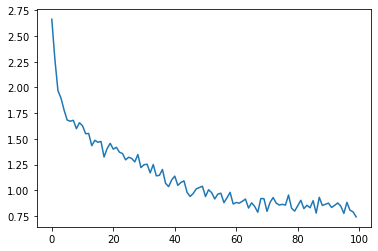

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

And output a confusion matrix, this takes 10,000 random examples, and
plots a matrix going from the true label on one axis and the networks
best guess for the label on the other. We can use this to see which
categories the network is confusing. (Here, we see that the network
often confuses Chinese and Korean names for instance).



<ipython-input-20-a5b341ffc3a3>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-20-a5b341ffc3a3>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


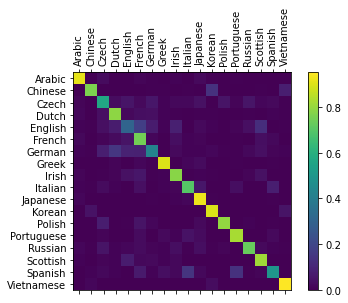

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

And some examples showing predictions of the network for a few
different names (using softmax to turn the output to prob.). Show the assigned probability for the
n<sub>predictions</sub> languages with the highest probability.



In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = torch.softmax(evaluate(lineToTensor(input_line)),1)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.3f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(0.755) Czech
(0.218) Russian
(0.017) English

> Jackson
(0.992) Scottish
(0.003) English
(0.003) Irish

> Satoshi
(0.847) Japanese
(0.134) Italian
(0.009) Greek


# Exercises <a id="exercises" />

Take the single hidden layer example shown in the lecture, and use it
as a starting point to create a two-layer recurrent neural network as
shown on page 8 of the lecture slides.

You should think about how to structure the hidden state output, conceptually, the two layers act like 2 independent RNNs where the output of the first feeds into the input of the second, as shown here:

In [ ]:
layer1 = RNN(57,128,512) # input_size, hidden_size, output_size
layer2 = RNN(512,128,n_categories)

hidden1 = layer1.initHidden()
hidden2 = layer2.initHidden()

output1, hidden1 = layer1(line_tensor[0], hidden1)
output2, hidden2 = layer2(output1, hidden2)
output2

tensor([[-0.0277,  0.0217, -0.0697,  0.0723,  0.0004, -0.0699, -0.0494,  0.1230,
         -0.0377,  0.0545,  0.0475,  0.0324, -0.0029, -0.0520, -0.0371,  0.0464,
          0.1157, -0.0738]], grad_fn=<AddmmBackward>)

One difference that your network should have compared to this would be that `output1` should be passed through an activation function, such as ReLU before going to the second layer in your network, whereas the above passes it through un-activated.

When you make your network, the hidden state should be give back the hidden state for both layers, so you should be able to write the hidden state initialization and network update like:
```
hidden = RNN2Layers.initHidden()
output, hidden = RNN2Layers(input, hidden)
```

Train the network on the name to country dataset.



Draw the confusion matrix for your two-layer hidden network.

